# Import data

In [111]:
import pandas as pd

# Read all sheets into a dictionary of DataFrames
# dfs = pd.read_excel('results-12-19.xlsx', sheet_name=None)
# dfs = pd.read_excel('results-12-22.xlsx', sheet_name=None)
# dfs = pd.read_excel('results-12-23.xlsx', sheet_name=None)
dfs = pd.read_excel('results-12-29-decision-sample.xlsx', sheet_name=None)

# Print the names of the sheets
print(dfs.keys())

dict_keys(['support increase', 'support decrease', 'confidence increase', 'confidence decrease', 'supp inc | conf inc', 'supp inc | conf dec', 'supp dec | conf inc', 'supp dec | conf dec', '(old change) supp inc|conf inc', '(old change) supp dec|conf dec', 'vary beta', 'vary |D| size', 'vary K'])


In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Set default figure size (width, height in inches)
plt.rcParams['figure.figsize'] = [4, 3]

plt.rcParams['font.size'] = 16

plt.rcParams['lines.markersize'] = 10  # Default marker size is 6

In [113]:
VERBOSE = False

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorMap = {
    "batch": colors[1],
    "IncMiner1.0": colors[0],
    "IncMiner": colors[0],
    "IncMiner0.7": colors[2],
    "IncMinerNS": colors[4],
    "IApriori": colors[3],
    "DCFinder": colors[5]
}

markerMap = {
    "batch": '^',
    "IncMiner1.0": 's',
    "IncMiner": 's',
    "IncMiner0.7": 'v',
    "IncMinerNS": '*',
    "IApriori": '+',
    "DCFinder": 'x'
    
}

markerStyleMap = {
    "batch": {'markerfacecolor': 'none', 'markeredgewidth': 1.0},
    "IncMiner1.0": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
    "IncMiner": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
    "IncMiner0.7": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
    "IncMinerNS": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
    "IApriori": {'markerfacecolor': 'auto', 'markeredgewidth': 1.0},
    "DCFinder": {'markerfacecolor': 'auto', 'markeredgewidth': 1.0},
}

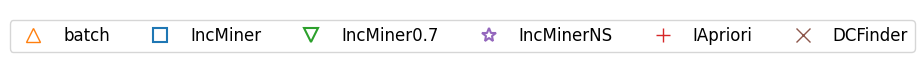

In [114]:
# Create legend elements, skipping "IncMiner1.0"
legend_elements = [
    plt.Line2D([0], [0], color=colorMap[label], marker=markerMap[label], 
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
               linestyle='', label=label)
    for label in colorMap.keys() if label != "IncMiner1.0"
]

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust width and height for a wide flat layout

# Remove axes
ax.axis('off')

# Add the legend
ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=True,
    fontsize=12,
    ncol=len(legend_elements),  # Arrange all legend entries in a single row
)

# Adjust layout
plt.tight_layout()

# Save or display the legend-only plot
plt.savefig("plots/legend.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [115]:
ylabel_time = "Running time (s)"

In [116]:
def post_process(_df):
    # 1. Compute scale factor of 'new support' over 'old support'
    _df['supportScale'] = _df['new support'] / _df['old support']

    # 2. Compute absolute difference of 'new confidence' over 'old confidence'
    _df['confDiff'] = _df['new confidence'] - _df['old confidence']
    
    # 3. Assign new label name
    _df['label'] = _df['Baseline'] + _df['beta'].fillna('').astype(str)
    
    # 4. Convert Mining time scale
    _df['time'] = _df['Mining time'] / 1000

    return _df

In [178]:
def compute_speedup(df, baseline_label, target_labels, metric="time"):
    """
    Compute the maximal and average speedup for target labels compared to a baseline label,
    replacing zero values with 1 to avoid division errors.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing timing data.
        baseline_label (str): The label of the baseline group (e.g., 'batch').
        target_labels (list): A list of labels for the groups to compare against the baseline.
    
    Returns:
        dict: A dictionary with the speedup results for each target label.
    """
    # Group by the "label" column
    groups = df.groupby('label')
    
    # Extract baseline times
    if baseline_label not in groups.groups:
        raise ValueError(f"Baseline label '{baseline_label}' not found in data.")
    
    # times_baseline = groups.get_group(baseline_label)['time'].replace(0, 1).values  # Replace 0 with 1
    times_baseline = groups.get_group(baseline_label)[metric].apply(lambda x: max(x, 1)).values  # Replace values < 1 with 1

    
    # Initialize results dictionary
    speedup_results = {}
    
    # Compute speedup for each target label
    for label in target_labels:
        if label not in groups.groups:
            print(f"Warning: Target label '{label}' not found in data. Skipping.")
            continue
        
        # times_target = groups.get_group(label)['time'].replace(0, 1).values  # Replace 0 with 1
        times_target = groups.get_group(label)[metric].apply(lambda x: max(x, 1)).values  # Replace values < 1 with 1

        
        # Ensure the baseline and target have the same number of entries
        if len(times_baseline) != len(times_target):
            raise ValueError(f"Mismatch in number of entries for baseline '{baseline_label}' and target '{label}'.")
        
        # Calculate speedup
        speedups = times_baseline / times_target
        
        # Store results
        speedup_results[label] = {
            "max_speedup": speedups.max(),
            "avg_speedup": speedups.mean()
        }
    
    return speedup_results

# Exp-3 : vary K

In [118]:
tab = 'vary K'
df = dfs[tab]
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,1,0.7,20,143727,...,NaN,24.901459,23.870969,1.030467,0,0.000023,1.0,-0.3,IncMiner0.7,143.727
1,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,2,0.7,20,146360,...,NaN,24.481539,23.331662,1.149854,0,0.000023,1.0,-0.3,IncMiner0.7,146.360
2,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.7,20,150679,...,NaN,24.033647,22.805283,1.228341,0,0.000023,1.0,-0.3,IncMiner0.7,150.679
3,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,4,0.7,20,153995,...,NaN,23.823119,22.489033,1.334064,0,0.000023,1.0,-0.3,IncMiner0.7,153.995
4,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,5,0.7,20,165975,...,NaN,23.589503,22.265990,1.323490,0,0.000023,1.0,-0.3,IncMiner0.7,165.975


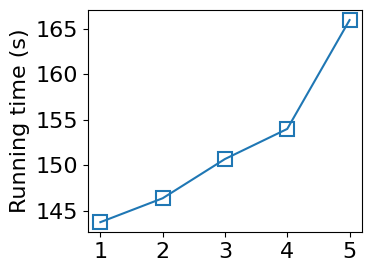

In [119]:
select = df['Baseline'] == 'IncMiner'
X = df[select]["K"]
Y = df[select]["time"] 

plt.figure()
label = "IncMiner"
plt.plot(X, Y, marker='s',
                        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),)  
plt.ylabel('Running time (s)')  # Label for the y-axis

xtick_labels = [str(x) for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.xlabel('K')  # Label for the x-axis
    plt.title('K vs Mining Time')  # Title of the plot
    
outfile = "plots/exp3_hospital_k_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    

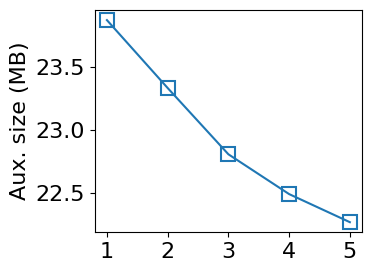

In [120]:
X = df[select]["K"]
Y = df[select]["auxiliary size"] 
# Y = df[select]["sample number"] 

# Plot the data
plt.figure()
plt.plot(X, Y, marker='s',                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 
plt.ylabel('Aux. size (MB)')  # Label for the y-axis


xtick_labels = [str(x) for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.title(tab)
    plt.xlabel('K')  # Label for the x-axis

outfile = "plots/exp3_hospital_k_storage.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight') 

# Show the plot
plt.show()

**Comments**:

Why at K=1, aux.size is the same as K=3. 
We also expect a positive correlation between K and auxiliary data size.

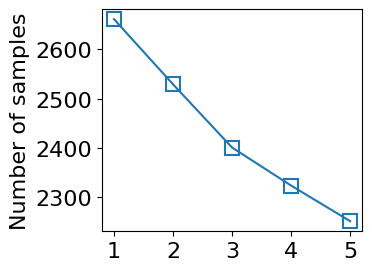

In [121]:
X = df[select]["K"]
Y = df[select]["sample number"] 

# Plot the data
plt.figure()
plt.plot(X, Y, marker="s",                 markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),)  # You can change the color and line style
plt.ylabel('Number of samples')  # Label for the y-axis

xtick_labels = [str(x) for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.title(tab)
    plt.xlabel('K')  # Label for the x-axis

outfile = "plots/exp3_hospital_k_samples.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight') 

# Show the plot
plt.show()

## Vary beta

In [186]:
df = dfs["vary beta"]
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.6,20,130973,...,NaN,23.928524,22.805283,1.123219,0,0.000023,1.0,-0.3,IncMiner0.6,130.973
1,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.7,20,153884,...,NaN,23.745255,22.805283,0.939950,0,0.000023,1.0,-0.3,IncMiner0.7,153.884
2,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.8,20,168663,...,NaN,23.948734,22.805283,1.143429,0,0.000023,1.0,-0.3,IncMiner0.8,168.663
3,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.9,20,191316,...,NaN,23.667345,22.805283,0.862040,0,0.000023,1.0,-0.3,IncMiner0.9,191.316
4,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,1.0,20,278490,...,NaN,23.464969,22.805283,0.659663,0,0.000023,1.0,-0.3,IncMiner1.0,278.490


0     85
1     89
2     91
3     96
4    100
Name: recall rate, dtype: int64


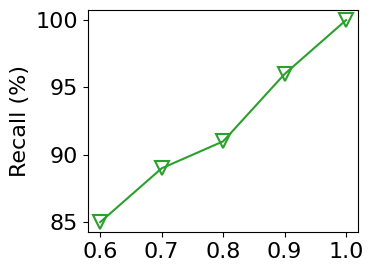

In [187]:

# Assuming 'Sample number' is a column in df and 'Mining time' is another column
X = df["beta"]
Y = (df["recall rate"] * 100).round().astype(int)
print(Y)

# Plot the data
label = "IncMiner0.7"
plt.plot(X, Y, marker=markerMap[label], color=colorMap[label],                
         markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 
plt.ylabel('Recall (%)')  # Label for the y-axis

xtick_labels = [f"{x:.1f}" for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.xlabel('beta')  # Label for the x-axis
    
outfile = "plots/exp3_hospital_beta_recall.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')     

# Show the plot
plt.show()

In [194]:
np.mean((df["recall rate"]-X)[0:4])

np.float64(0.15026595744680823)

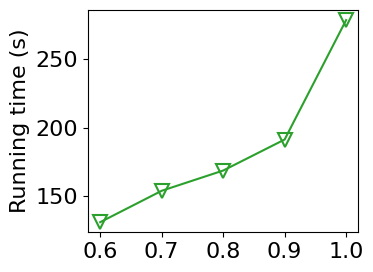

In [124]:
X = df["beta"]
Y = df["time"]

# Plot the data
label = "IncMiner0.7"
plt.plot(X, Y, marker=markerMap[label], color=colorMap[label],
                        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 
plt.ylabel('Running time (s)')  # Label for the y-axis

xtick_labels = [f"{x:.1f}" for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.xlabel('beta')  # Label for the x-axis
    
outfile = "plots/exp3_hospital_beta_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')  

# Show the plot
plt.show()

## Comments

Now the mining time is too fast. May use a larger dataset.

# Exp-2

## Vary |D|

In [168]:
tab = 'vary |D| size'

df = dfs[tab]
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,|D| size,Mining time,...,taskId,minimal size,decision tree REE number,decision tree size,total size,not decision tree ree,supportScale,confDiff,label,time
0,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.2,88865,...,1002992,1.470077,4357,17.855036,68.824582,395,0.1,-0.1,IncMiner0.7,88.865
1,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.4,153066,...,1002993,1.556261,5943,24.667562,113.636271,426,0.1,-0.1,IncMiner0.7,153.066
2,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.6,203954,...,1002994,1.611220,6798,28.762400,154.105046,453,0.1,-0.1,IncMiner0.7,203.954
3,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.8,222347,...,1002995,1.665271,6715,28.881948,189.585740,467,0.1,-0.1,IncMiner0.7,222.347
4,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,1.0,236622,...,1002996,1.902609,6226,26.951264,222.412769,542,0.1,-0.1,IncMiner0.7,236.622
5,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.2,175882,...,1002997,1.294251,11683,47.742509,98.536230,351,0.1,-0.1,IncMiner1.0,175.882
6,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.4,280402,...,1002998,1.495427,14632,60.393650,149.301526,433,0.1,-0.1,IncMiner1.0,280.402
7,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.6,381101,...,1002999,1.428326,16166,68.219078,193.378830,422,0.1,-0.1,IncMiner1.0,381.101
8,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.8,467858,...,1003000,1.465869,18321,77.747424,238.251814,429,0.1,-0.1,IncMiner1.0,467.858
9,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,1.0,533144,...,1003001,1.703932,18032,77.409133,272.671961,488,0.1,-0.1,IncMiner1.0,533.144


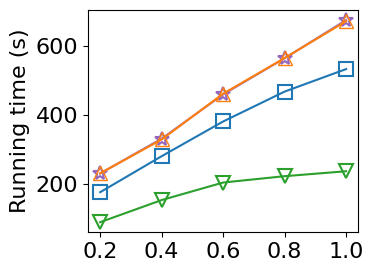

{'IncMiner0.7': {'max_speedup': np.float64(2.253146368469542),
  'avg_speedup': np.float64(2.007399272089911)}}

In [171]:
# Group by the "label" column
groups = df.groupby('label')

plt.figure()
for label, group in groups:
    plt.plot(group['|D| size'], group['time'], label=label, color=colorMap[label], marker=markerMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
if VERBOSE:
    plt.legend()
    plt.xlabel('|D|')  # Label for the x-axis
plt.ylabel(ylabel_time)

xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_dblp_d_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')  

# Show the plot
plt.show()

compute_speedup(df, "batch", ["IncMiner1.0", "IncMiner0.7"])

compute_speedup(df, "IncMiner1.0", ["IncMiner0.7"])

IncMiner0.7
0    19.325112
1    26.223823
2    30.373620
3    30.547219
4    28.853873
Name: output size, dtype: float64
IncMiner1.0
5    49.036760
6    61.889077
7    69.647404
8    79.213293
9    79.113065
Name: output size, dtype: float64
IncMinerNS
10    51.238997
11    65.055752
12    73.072802
13    90.128104
14    97.893674
Name: output size, dtype: float64
batch
15    51.238997
16    65.055752
17    73.072802
18    90.128104
19    97.893674
Name: output size, dtype: float64


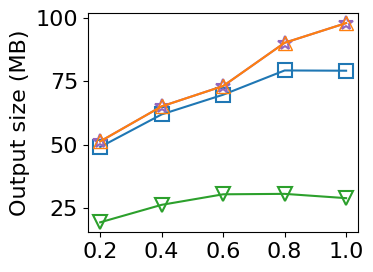

In [172]:
plt.figure()
for label, group in groups:
    print (label)
    print (group['output size'])
    plt.plot(group['|D| size'], group['output size'], label=label, color=colorMap[label], marker=markerMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
plt.ylabel('Output size (MB)')  # Label for the y-axis
if VERBOSE:
    plt.xlabel('|D|')  # Label for the x-axis
    plt.title(tab)
    plt.legend()
    
xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_dblp_d_output.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')      
    
# Show the plot
plt.show()

Questions:
    1. Why IncMiner has smaller output size than batchMiner?
    2. Why IncMienr0.7 has less than 50% output size of BatchMiner? By design it should has at least 70%.

IncMiner0.7
0     49.499470
1     87.412449
2    123.731426
3    159.038521
4    193.558896
Name: auxiliary size, dtype: float64
IncMiner1.0
5     49.499470
6     87.412449
7    123.731426
8    159.038521
9    193.558896
Name: auxiliary size, dtype: float64
IncMinerNS
10     39.883951
11     77.210028
12    113.242830
13    148.298227
14    182.556625
Name: auxiliary size, dtype: float64


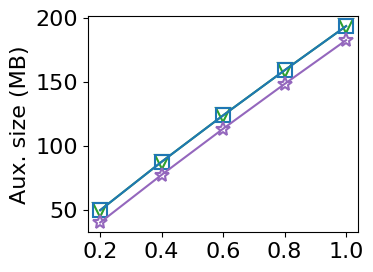

{'IncMinerNS': {'max_speedup': np.float64(1.2410874119474946),
  'avg_speedup': np.float64(1.1197075378596328)}}

In [180]:
plt.figure()
for label, group in groups:
    if label == 'batch':
        continue
        
    print (label)
    print (group['auxiliary size'])
    plt.plot(group['|D| size'], group['auxiliary size'], label=label, color=colorMap[label], 
             marker=markerMap[label],
             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
plt.ylabel('Aux. size (MB)')  # Label for the y-axis
if VERBOSE:
    plt.xlabel('|D|')  # Label for the x-axis
    plt.title(tab)
    plt.legend()
    
xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_dblp_d_aux.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')      

# Show the plot
plt.show()

compute_speedup(df, "IncMiner1.0", ["IncMinerNS"], metric='auxiliary size')

**Comments**: 

IncMinerNS is expcted to have less auxiliary data 
as it stores no samples.

# Exp-1

## support increase

In [129]:
tab = 'support increase'
df = dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.adult,0.000001,0.75,0.00001,0.75,IncMiner,3,0.7,20,0,...,NaN,22.466193,21.552022,0.914148,0,0.000023,10.0,0.0,IncMiner0.7,0.000
1,inc_rds.adult,0.000001,0.75,0.00010,0.75,IncMiner,3,0.7,20,0,...,NaN,21.885167,21.552022,0.333122,0,0.000023,100.0,0.0,IncMiner0.7,0.000
2,inc_rds.adult,0.000001,0.75,0.00100,0.75,IncMiner,3,0.7,20,0,...,NaN,21.865067,21.552022,0.313022,0,0.000023,1000.0,0.0,IncMiner0.7,0.000
3,inc_rds.adult,0.000001,0.75,0.01000,0.75,IncMiner,3,0.7,20,0,...,NaN,21.803052,21.552022,0.251007,0,0.000023,10000.0,0.0,IncMiner0.7,0.000
4,inc_rds.adult,0.000001,0.75,0.00001,0.75,IncMiner,3,NaN,20,0,...,NaN,22.466193,21.552022,0.914148,0,0.000023,10.0,0.0,IncMiner,0.000
5,inc_rds.adult,0.000001,0.75,0.00010,0.75,IncMiner,3,NaN,20,0,...,NaN,21.885167,21.552022,0.333122,0,0.000023,100.0,0.0,IncMiner,0.000
6,inc_rds.adult,0.000001,0.75,0.00100,0.75,IncMiner,3,NaN,20,0,...,NaN,21.865067,21.552022,0.313022,0,0.000023,1000.0,0.0,IncMiner,0.000
7,inc_rds.adult,0.000001,0.75,0.01000,0.75,IncMiner,3,NaN,20,0,...,NaN,21.803052,21.552022,0.251007,0,0.000023,10000.0,0.0,IncMiner,0.000
8,inc_rds.adult,0.000001,0.75,0.00001,0.75,IncMinerNS,3,NaN,20,0,...,NaN,3.369110,2.454939,0.914148,0,0.000023,10.0,0.0,IncMinerNS,0.000
9,inc_rds.adult,0.000001,0.75,0.00010,0.75,IncMinerNS,3,NaN,20,0,...,NaN,2.788084,2.454939,0.333122,0,0.000023,100.0,0.0,IncMinerNS,0.000


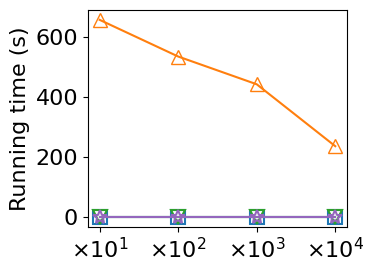

{'IncMiner': {'max_speedup': np.float64(658.082),
  'avg_speedup': np.float64(468.51325)},
 'IncMiner0.7': {'max_speedup': np.float64(658.082),
  'avg_speedup': np.float64(468.51325)}}

In [130]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    X = group['supportScale']
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                            markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 

# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis
# plt.xscale("log")

xtick_labels = [fr"$\times 10^{{{int(np.log10(value))}}}$" for value in X]
plt.xticks(range(len(X)), xtick_labels)


if VERBOSE:
    plt.xlabel('supportScale')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_increase_supp.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## support decrease

In [149]:
tab = 'support decrease'
df =dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.01,0.75,0.001000,0.75,IncMiner,3,0.7,20,2005,...,NaN,29.787149,29.787104,0.000023,0,0.000023,0.1000,0.0,IncMiner0.7,2.005
1,inc_rds.inspection,0.01,0.75,0.000100,0.75,IncMiner,3,0.7,20,18758,...,NaN,30.076203,29.967672,0.108508,0,0.000023,0.0100,0.0,IncMiner0.7,18.758
2,inc_rds.inspection,0.01,0.75,0.000010,0.75,IncMiner,3,0.7,20,167490,...,NaN,30.154875,29.890682,0.264170,0,0.000023,0.0010,0.0,IncMiner0.7,167.490
3,inc_rds.inspection,0.01,0.75,0.000001,0.75,IncMiner,3,0.7,20,335200,...,NaN,30.017729,29.133776,0.883930,0,0.000023,0.0001,0.0,IncMiner0.7,335.200
4,inc_rds.inspection,0.01,0.75,0.001000,0.75,IncMiner,3,NaN,20,1891,...,NaN,29.787149,29.787104,0.000023,0,0.000023,0.1000,0.0,IncMiner,1.891
5,inc_rds.inspection,0.01,0.75,0.000100,0.75,IncMiner,3,NaN,20,18833,...,NaN,30.076203,29.967672,0.108508,0,0.000023,0.0100,0.0,IncMiner,18.833
6,inc_rds.inspection,0.01,0.75,0.000010,0.75,IncMiner,3,NaN,20,168100,...,NaN,30.154875,29.890682,0.264170,0,0.000023,0.0010,0.0,IncMiner,168.100
7,inc_rds.inspection,0.01,0.75,0.000001,0.75,IncMiner,3,NaN,20,336663,...,NaN,30.017729,29.133776,0.883930,0,0.000023,0.0001,0.0,IncMiner,336.663
8,inc_rds.inspection,0.01,0.75,0.001000,0.75,IncMinerNS,3,NaN,20,2048,...,NaN,29.736165,29.736119,0.000023,0,0.000023,0.1000,0.0,IncMinerNS,2.048
9,inc_rds.inspection,0.01,0.75,0.000100,0.75,IncMinerNS,3,NaN,20,18863,...,NaN,30.025219,29.916688,0.108508,0,0.000023,0.0100,0.0,IncMinerNS,18.863


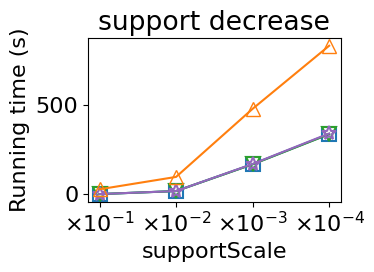

{'IncMiner': {'max_speedup': np.float64(15.167107350608145),
  'avg_speedup': np.float64(6.409235855055611)},
 'IncMiner0.7': {'max_speedup': np.float64(14.304738154613467),
  'avg_speedup': np.float64(6.204081508943939)}}

In [151]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()  # Adjust the figure size if needed

for label, group in groups:
    X = group['supportScale']
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis
# plt.xscale("log")

xtick_labels = [fr"$\times 10^{{{int(np.log10(value))}}}$" for value in X]
plt.xticks(range(len(X)), xtick_labels)


# if VERBOSE:
if True:
    plt.xlabel('supportScale')  # Label for x-axis
    plt.title(tab)
    # plt.legend()
    
outfile = "plots/exp1_inspection_decrease_supp.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

**Comments**:

Expect a consistent gap between batch and the rest.
At small \Delta \sigma, the gap is close to zero.

## confidence increase

In [155]:
tab = 'confidence increase'
df =dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.7,0.000001,0.75,IncMiner,3,0.7,20,9353,...,NaN,35.316135,34.466459,0.849653,0,0.000023,1.0,0.05,IncMiner0.7,9.353
1,inc_rds.inspection,0.000001,0.7,0.000001,0.80,IncMiner,3,0.7,20,24568,...,NaN,36.150887,35.159388,0.991477,0,0.000023,1.0,0.10,IncMiner0.7,24.568
2,inc_rds.inspection,0.000001,0.7,0.000001,0.85,IncMiner,3,0.7,20,52073,...,NaN,37.157378,36.108680,1.048676,0,0.000023,1.0,0.15,IncMiner0.7,52.073
3,inc_rds.inspection,0.000001,0.7,0.000001,0.90,IncMiner,3,0.7,20,104400,...,NaN,38.104409,36.914202,1.190185,0,0.000023,1.0,0.20,IncMiner0.7,104.400
4,inc_rds.inspection,0.000001,0.7,0.000001,0.95,IncMiner,3,0.7,20,190222,...,NaN,39.439556,38.200987,1.238546,0,0.000023,1.0,0.25,IncMiner0.7,190.222
5,inc_rds.inspection,0.000001,0.7,0.000001,0.75,IncMiner,3,NaN,20,8999,...,NaN,35.316135,34.466459,0.849653,0,0.000023,1.0,0.05,IncMiner,8.999
6,inc_rds.inspection,0.000001,0.7,0.000001,0.80,IncMiner,3,NaN,20,24601,...,NaN,36.150887,35.159388,0.991477,0,0.000023,1.0,0.10,IncMiner,24.601
7,inc_rds.inspection,0.000001,0.7,0.000001,0.85,IncMiner,3,NaN,20,52077,...,NaN,37.157378,36.108680,1.048676,0,0.000023,1.0,0.15,IncMiner,52.077
8,inc_rds.inspection,0.000001,0.7,0.000001,0.90,IncMiner,3,NaN,20,103522,...,NaN,38.104409,36.914202,1.190185,0,0.000023,1.0,0.20,IncMiner,103.522
9,inc_rds.inspection,0.000001,0.7,0.000001,0.95,IncMiner,3,NaN,20,191103,...,NaN,39.439556,38.200987,1.238546,0,0.000023,1.0,0.25,IncMiner,191.103


<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_78816/3748121871.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \delta$")  # Label for x-axis


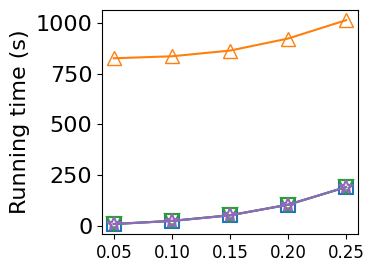

{'IncMiner': {'max_speedup': np.float64(91.69341037893099),
  'avg_speedup': np.float64(31.282392435721597)},
 'IncMiner0.7': {'max_speedup': np.float64(88.22292312626965),
  'avg_speedup': np.float64(30.58759311992673)}}

In [156]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    plt.plot(group['confDiff'], group['time'], label=label, marker=markerMap[label], color=colorMap[label],
            markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),)

# Add plot labels and legend
plt.ylabel(ylabel_time)

if VERBOSE:
    plt.xlabel("$\Delta \delta$")  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
        
plt.tick_params(axis='x', labelsize=12)  

outfile = "plots/exp1_inspection_increase_conf.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## confidence decrease

In [158]:
tab = 'confidence decrease'
df =dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.95,0.000001,0.90,IncMiner,3,0.7,20,70536,...,NaN,40.997581,39.702646,1.294912,0,0.000023,1.0,-0.05,IncMiner0.7,70.536
1,inc_rds.inspection,0.000001,0.95,0.000001,0.85,IncMiner,3,0.7,20,92183,...,NaN,41.010135,39.702646,1.307466,0,0.000023,1.0,-0.10,IncMiner0.7,92.183
2,inc_rds.inspection,0.000001,0.95,0.000001,0.80,IncMiner,3,0.7,20,98205,...,NaN,40.992496,39.702646,1.289826,0,0.000023,1.0,-0.15,IncMiner0.7,98.205
3,inc_rds.inspection,0.000001,0.95,0.000001,0.75,IncMiner,3,0.7,20,103631,...,NaN,40.945346,39.702646,1.242677,0,0.000023,1.0,-0.20,IncMiner0.7,103.631
4,inc_rds.inspection,0.000001,0.95,0.000001,0.70,IncMiner,3,0.7,20,113008,...,NaN,40.941546,39.702646,1.238877,0,0.000023,1.0,-0.25,IncMiner0.7,113.008
5,inc_rds.inspection,0.000001,0.95,0.000001,0.90,IncMiner,3,NaN,20,183982,...,NaN,40.801917,39.702646,1.099248,0,0.000023,1.0,-0.05,IncMiner,183.982
6,inc_rds.inspection,0.000001,0.95,0.000001,0.85,IncMiner,3,NaN,20,185829,...,NaN,40.646017,39.702646,0.943348,0,0.000023,1.0,-0.10,IncMiner,185.829
7,inc_rds.inspection,0.000001,0.95,0.000001,0.80,IncMiner,3,NaN,20,182575,...,NaN,40.576019,39.702646,0.873350,0,0.000023,1.0,-0.15,IncMiner,182.575
8,inc_rds.inspection,0.000001,0.95,0.000001,0.75,IncMiner,3,NaN,20,190047,...,NaN,40.467529,39.702646,0.764860,0,0.000023,1.0,-0.20,IncMiner,190.047
9,inc_rds.inspection,0.000001,0.95,0.000001,0.70,IncMiner,3,NaN,20,202153,...,NaN,40.503951,39.702646,0.801282,0,0.000023,1.0,-0.25,IncMiner,202.153


<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_78816/661808557.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \delta$")  # Label for x-axis


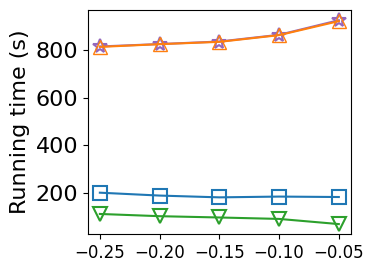

{'IncMiner': {'max_speedup': np.float64(5.007163744279332), 'avg_speedup': np.float64(4.516225009409854)}, 'IncMiner0.7': {'max_speedup': np.float64(13.060394692072132), 'avg_speedup': np.float64(9.213562017632572)}}
{'IncMiner0.7': {'max_speedup': np.float64(2.6083418396279914), 'avg_speedup': np.float64(2.021210676549599)}}


In [160]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    plt.plot(group['confDiff'], group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            )

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis


if VERBOSE:
    plt.xlabel("$\Delta \delta$")  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
plt.tick_params(axis='x', labelsize=12)  

outfile = "plots/exp1_inspection_decrease_conf.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
# Display the plot
plt.show()

# Compute speedup
print(compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7']))

print(compute_speedup(df, 'IncMiner', ['IncMiner0.7']))

## s+c+

In [137]:
tab = 'supp inc | conf inc'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.7,0.00001,0.75,IncMiner,3,0.7,20,5752,...,NaN,38.744583,38.442465,0.302095,0,0.000023,10.0,0.05,IncMiner0.7,5.752
1,inc_rds.inspection,0.000001,0.7,0.00010,0.80,IncMiner,3,0.7,20,4580,...,NaN,39.190511,39.017492,0.172996,0,0.000023,100.0,0.10,IncMiner0.7,4.580
2,inc_rds.inspection,0.000001,0.7,0.00100,0.85,IncMiner,3,0.7,20,1214,...,NaN,39.060520,39.060474,0.000023,0,0.000023,1000.0,0.15,IncMiner0.7,1.214
3,inc_rds.inspection,0.000001,0.7,0.01000,0.90,IncMiner,3,0.7,20,774,...,NaN,39.041077,39.041031,0.000023,0,0.000023,10000.0,0.20,IncMiner0.7,0.774
4,inc_rds.inspection,0.000001,0.7,0.00001,0.75,IncMiner,3,NaN,20,5336,...,NaN,38.744583,38.442465,0.302095,0,0.000023,10.0,0.05,IncMiner,5.336
5,inc_rds.inspection,0.000001,0.7,0.00010,0.80,IncMiner,3,NaN,20,4592,...,NaN,39.190511,39.017492,0.172996,0,0.000023,100.0,0.10,IncMiner,4.592
6,inc_rds.inspection,0.000001,0.7,0.00100,0.85,IncMiner,3,NaN,20,1292,...,NaN,39.060520,39.060474,0.000023,0,0.000023,1000.0,0.15,IncMiner,1.292
7,inc_rds.inspection,0.000001,0.7,0.01000,0.90,IncMiner,3,NaN,20,914,...,NaN,39.041077,39.041031,0.000023,0,0.000023,10000.0,0.20,IncMiner,0.914
8,inc_rds.inspection,0.000001,0.7,0.00001,0.75,IncMinerNS,3,NaN,20,5383,...,NaN,30.859060,30.556942,0.302095,0,0.000023,10.0,0.05,IncMinerNS,5.383
9,inc_rds.inspection,0.000001,0.7,0.00010,0.80,IncMinerNS,3,NaN,20,4126,...,NaN,31.365912,31.192894,0.172996,0,0.000023,100.0,0.10,IncMinerNS,4.126


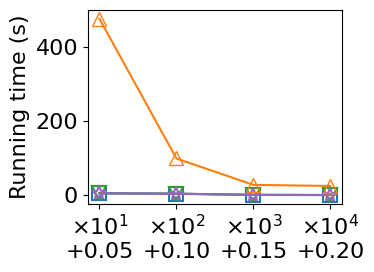

{'IncMiner': {'max_speedup': np.float64(89.44415292353823),
  'avg_speedup': np.float64(40.19622101385764)},
 'IncMiner0.7': {'max_speedup': np.float64(82.97531293463143),
  'avg_speedup': np.float64(40.1994087912299)}}

In [138]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            )
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_s+c+_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## S+C-

In [161]:
tab = 'supp inc | conf dec'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.adult,0.000001,0.95,0.00001,0.90,IncMiner,3,0.7,20,41129,...,NaN,33.431380,32.487323,0.944035,0,0.000023,10.0,-0.05,IncMiner0.7,41.129
1,inc_rds.adult,0.000001,0.95,0.00010,0.85,IncMiner,3,0.7,20,62658,...,NaN,33.282404,32.487323,0.795058,0,0.000023,100.0,-0.10,IncMiner0.7,62.658
2,inc_rds.adult,0.000001,0.95,0.00100,0.80,IncMiner,3,0.7,20,83089,...,NaN,33.288024,32.487323,0.800678,0,0.000023,1000.0,-0.15,IncMiner0.7,83.089
3,inc_rds.adult,0.000001,0.95,0.01000,0.75,IncMiner,3,0.7,20,95213,...,NaN,33.485996,32.487323,0.998651,0,0.000023,10000.0,-0.20,IncMiner0.7,95.213
4,inc_rds.adult,0.000001,0.95,0.00001,0.90,IncMiner,3,NaN,20,93398,...,NaN,33.125797,32.487323,0.638452,0,0.000023,10.0,-0.05,IncMiner,93.398
5,inc_rds.adult,0.000001,0.95,0.00010,0.85,IncMiner,3,NaN,20,113576,...,NaN,32.958278,32.487323,0.470932,0,0.000023,100.0,-0.10,IncMiner,113.576
6,inc_rds.adult,0.000001,0.95,0.00100,0.80,IncMiner,3,NaN,20,135730,...,NaN,32.907110,32.487323,0.419765,0,0.000023,1000.0,-0.15,IncMiner,135.730
7,inc_rds.adult,0.000001,0.95,0.01000,0.75,IncMiner,3,NaN,20,154248,...,NaN,32.951196,32.487323,0.463850,0,0.000023,10000.0,-0.20,IncMiner,154.248
8,inc_rds.adult,0.000001,0.95,0.00001,0.90,IncMinerNS,3,NaN,20,959334,...,NaN,78.830587,2.454939,1.280627,19370,75.095021,10.0,-0.05,IncMinerNS,959.334
9,inc_rds.adult,0.000001,0.95,0.00010,0.85,IncMinerNS,3,NaN,20,676301,...,NaN,74.187055,2.638958,0.220093,18463,71.328004,100.0,-0.10,IncMinerNS,676.301


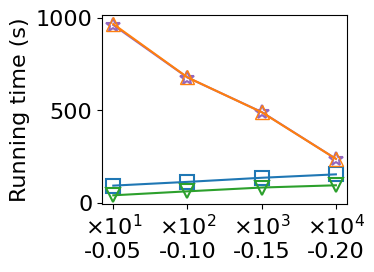

{'IncMiner0.7': {'max_speedup': np.float64(2.270855114396168),
  'avg_speedup': np.float64(1.8342673054915448)}}

In [162]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                            markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),)
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_s+c-_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

compute_speedup(df, 'IncMiner', ['IncMiner0.7'])

## S-C+

In [141]:
tab = 'supp dec | conf inc'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.01,0.7,0.001000,0.75,IncMiner,3,0.7,20,2131,...,NaN,29.846432,29.846386,0.000023,0,0.000023,0.1000,0.05,IncMiner0.7,2.131
1,inc_rds.inspection,0.01,0.7,0.000100,0.80,IncMiner,3,0.7,20,18994,...,NaN,30.724841,30.576385,0.148433,0,0.000023,0.0100,0.10,IncMiner0.7,18.994
2,inc_rds.inspection,0.01,0.7,0.000010,0.85,IncMiner,3,0.7,20,176400,...,NaN,35.128071,34.809259,0.318789,0,0.000023,0.0010,0.15,IncMiner0.7,176.400
3,inc_rds.inspection,0.01,0.7,0.000001,0.90,IncMiner,3,0.7,20,407654,...,NaN,40.154231,38.857201,1.297008,0,0.000023,0.0001,0.20,IncMiner0.7,407.654
4,inc_rds.inspection,0.01,0.7,0.001000,0.75,IncMiner,3,NaN,20,2104,...,NaN,29.846432,29.846386,0.000023,0,0.000023,0.1000,0.05,IncMiner,2.104
5,inc_rds.inspection,0.01,0.7,0.000100,0.80,IncMiner,3,NaN,20,19184,...,NaN,30.724841,30.576385,0.148433,0,0.000023,0.0100,0.10,IncMiner,19.184
6,inc_rds.inspection,0.01,0.7,0.000010,0.85,IncMiner,3,NaN,20,176822,...,NaN,35.128071,34.809259,0.318789,0,0.000023,0.0010,0.15,IncMiner,176.822
7,inc_rds.inspection,0.01,0.7,0.000001,0.90,IncMiner,3,NaN,20,412069,...,NaN,40.154231,38.857201,1.297008,0,0.000023,0.0001,0.20,IncMiner,412.069
8,inc_rds.inspection,0.01,0.7,0.001000,0.75,IncMinerNS,3,NaN,20,1941,...,NaN,29.738338,29.738293,0.000023,0,0.000023,0.1000,0.05,IncMinerNS,1.941
9,inc_rds.inspection,0.01,0.7,0.000100,0.80,IncMinerNS,3,NaN,20,18989,...,NaN,30.094937,29.946482,0.148433,0,0.000023,0.0100,0.10,IncMinerNS,18.989


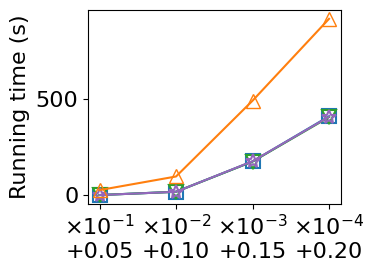

{'IncMiner': {'max_speedup': np.float64(13.224334600760457),
  'avg_speedup': np.float64(5.846392129566542)},
 'IncMiner0.7': {'max_speedup': np.float64(13.056780854059129),
  'avg_speedup': np.float64(5.825069877538627)}}

In [142]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            )
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_s-c+_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## S-C-

In [143]:
tab = 'supp dec | conf dec'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.adult,0.01,0.95,0.001000,0.90,IncMiner,3,0.7,20,85188,...,NaN,23.260915,22.703724,0.557168,0,0.000023,0.1000,-0.05,IncMiner0.7,85.188
1,inc_rds.adult,0.01,0.95,0.000100,0.85,IncMiner,3,0.7,20,113202,...,NaN,23.360587,23.131517,0.229047,0,0.000023,0.0100,-0.10,IncMiner0.7,113.202
2,inc_rds.adult,0.01,0.95,0.000010,0.80,IncMiner,3,0.7,20,151524,...,NaN,27.566978,26.110974,1.455980,0,0.000023,0.0010,-0.15,IncMiner0.7,151.524
3,inc_rds.adult,0.01,0.95,0.000001,0.75,IncMiner,3,0.7,20,140903,...,NaN,26.043496,25.160165,0.883308,0,0.000023,0.0001,-0.20,IncMiner0.7,140.903
4,inc_rds.adult,0.01,0.95,0.001000,0.90,IncMiner,3,NaN,20,91992,...,NaN,22.799806,22.703724,0.096059,0,0.000023,0.1000,-0.05,IncMiner,91.992
5,inc_rds.adult,0.01,0.95,0.000100,0.85,IncMiner,3,NaN,20,136469,...,NaN,23.287914,23.131517,0.156374,0,0.000023,0.0100,-0.10,IncMiner,136.469
6,inc_rds.adult,0.01,0.95,0.000010,0.80,IncMiner,3,NaN,20,180256,...,NaN,26.822969,26.110974,0.711972,0,0.000023,0.0010,-0.15,IncMiner,180.256
7,inc_rds.adult,0.01,0.95,0.000001,0.75,IncMiner,3,NaN,20,170247,...,NaN,25.913152,25.160165,0.752964,0,0.000023,0.0001,-0.20,IncMiner,170.247
8,inc_rds.adult,0.01,0.95,0.001000,0.90,IncMinerNS,3,NaN,20,650705,...,NaN,62.286907,5.137802,0.118011,14805,57.031095,0.1000,-0.05,IncMinerNS,650.705
9,inc_rds.adult,0.01,0.95,0.000100,0.85,IncMinerNS,3,NaN,20,684220,...,NaN,74.702353,2.638958,0.220093,18607,71.843302,0.0100,-0.10,IncMinerNS,684.220


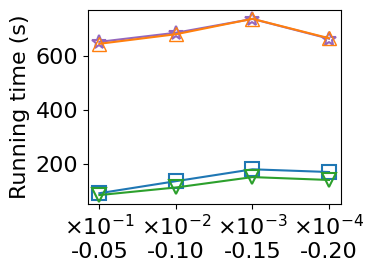

{'IncMiner': {'max_speedup': np.float64(6.995706148360727),
  'avg_speedup': np.float64(4.987962296023073)},
 'IncMiner0.7': {'max_speedup': np.float64(7.554456026670422),
  'avg_speedup': np.float64(5.779800397237365)}}

In [144]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            )
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_s-c-_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

**Comments**:

Should exhibit some monotoniciy: the 3rd or 4th data point rerun?

# Change initial parameters

## S+C+

In [164]:
tab = '(old change) supp inc|conf inc'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.75,0.00001,0.80,IncMiner,3,0.7,20,4830,...,NaN,37.130666,36.768492,0.362151,0,0.000023,10.0,0.05,IncMiner0.7,4.830
1,inc_rds.inspection,0.000010,0.80,0.00010,0.85,IncMiner,3,0.7,20,8270,...,NaN,34.527855,34.376399,0.151433,0,0.000023,10.0,0.05,IncMiner0.7,8.270
2,inc_rds.inspection,0.000100,0.85,0.00100,0.90,IncMiner,3,0.7,20,2,...,NaN,33.445442,33.445396,0.000023,0,0.000023,10.0,0.05,IncMiner0.7,0.002
3,inc_rds.inspection,0.001000,0.90,0.01000,0.95,IncMiner,3,0.7,20,0,...,NaN,31.665974,31.665928,0.000023,0,0.000023,10.0,0.05,IncMiner0.7,0.000
4,inc_rds.inspection,0.000001,0.75,0.00001,0.80,IncMiner,3,NaN,20,5102,...,NaN,37.130666,36.768492,0.362151,0,0.000023,10.0,0.05,IncMiner,5.102
5,inc_rds.inspection,0.000010,0.80,0.00010,0.85,IncMiner,3,NaN,20,8402,...,NaN,34.527855,34.376399,0.151433,0,0.000023,10.0,0.05,IncMiner,8.402
6,inc_rds.inspection,0.000100,0.85,0.00100,0.90,IncMiner,3,NaN,20,2,...,NaN,33.445442,33.445396,0.000023,0,0.000023,10.0,0.05,IncMiner,0.002
7,inc_rds.inspection,0.001000,0.90,0.01000,0.95,IncMiner,3,NaN,20,0,...,NaN,31.665974,31.665928,0.000023,0,0.000023,10.0,0.05,IncMiner,0.000
8,inc_rds.inspection,0.000001,0.75,0.00001,0.80,IncMinerNS,3,NaN,20,5024,...,NaN,31.009304,30.647130,0.362151,0,0.000023,10.0,0.05,IncMinerNS,5.024
9,inc_rds.inspection,0.000010,0.80,0.00010,0.85,IncMinerNS,3,NaN,20,8389,...,NaN,31.658413,31.506957,0.151433,0,0.000023,10.0,0.05,IncMinerNS,8.389


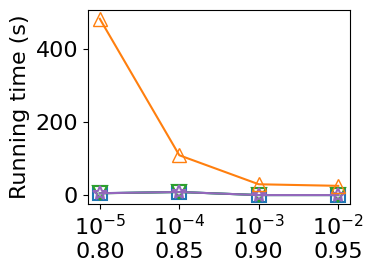

{'IncMiner': {'max_speedup': np.float64(94.35985887887102),
  'avg_speedup': np.float64(40.4952897613745)},
 'IncMiner0.7': {'max_speedup': np.float64(99.67370600414078),
  'avg_speedup': np.float64(41.87538357479578)}}

In [165]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            )
    
xtick_labels = [fr"$10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['new support'], group['new confidence'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_s+c+_lambda_init.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## S-C-

In [166]:
tab = '(old change) supp dec|conf dec'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.adult,0.01000,0.95,0.001000,0.90,IncMiner,3,0.7,20,86783,...,NaN,23.226618,22.669427,0.557168,0,0.000023,0.1,-0.05,IncMiner0.7,86.783
1,inc_rds.adult,0.00100,0.90,0.000100,0.85,IncMiner,3,0.7,20,52267,...,NaN,21.886054,21.719335,0.166697,0,0.000023,0.1,-0.05,IncMiner0.7,52.267
2,inc_rds.adult,0.00010,0.85,0.000010,0.80,IncMiner,3,0.7,20,38715,...,NaN,11.015384,10.842013,0.173347,0,0.000023,0.1,-0.05,IncMiner0.7,38.715
3,inc_rds.adult,0.00001,0.80,0.000001,0.75,IncMiner,3,0.7,20,1936,...,NaN,2.628332,2.454962,0.173347,0,0.000023,0.1,-0.05,IncMiner0.7,1.936
4,inc_rds.adult,0.01000,0.95,0.001000,0.90,IncMiner,3,NaN,20,95066,...,NaN,22.765509,22.669427,0.096059,0,0.000023,0.1,-0.05,IncMiner,95.066
5,inc_rds.adult,0.00100,0.90,0.000100,0.85,IncMiner,3,NaN,20,77217,...,NaN,21.860377,21.719335,0.141020,0,0.000023,0.1,-0.05,IncMiner,77.217
6,inc_rds.adult,0.00010,0.85,0.000010,0.80,IncMiner,3,NaN,20,68267,...,NaN,11.043552,10.842013,0.201516,0,0.000023,0.1,-0.05,IncMiner,68.267
7,inc_rds.adult,0.00001,0.80,0.000001,0.75,IncMiner,3,NaN,20,6844,...,NaN,2.628332,2.454962,0.173347,0,0.000023,0.1,-0.05,IncMiner,6.844
8,inc_rds.adult,0.01000,0.95,0.001000,0.90,IncMinerNS,3,NaN,20,654631,...,NaN,62.330295,5.137802,0.118011,14818,57.074482,0.1,-0.05,IncMinerNS,654.631
9,inc_rds.adult,0.00100,0.90,0.000100,0.85,IncMinerNS,3,NaN,20,685976,...,NaN,74.718719,2.638958,0.220093,18611,71.859669,0.1,-0.05,IncMinerNS,685.976


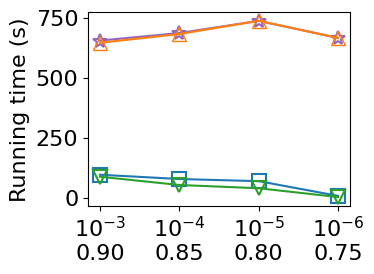

{'IncMiner': {'max_speedup': np.float64(97.18249561659847),
  'avg_speedup': np.float64(30.898762206958267)},
 'IncMiner0.7': {'max_speedup': np.float64(343.5521694214876),
  'avg_speedup': np.float64(95.76680301580429)}}

In [167]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            )
    
xtick_labels = [fr"$10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['new support'], group['new confidence'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_s-c-_lambda_init.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

**Comments**:

Should exhibit some monotoniciy: the 3rd or 4th data point rerun?